# Building a GPT from Scratch
---

This is an extended version of Andrej Karpathy's notebook in addition to his [Zero To Hero](https://karpathy.ai/zero-to-hero.html) video on GPT.

Adapted by: 

Prof. Dr.-Ing. Antje Muntzinger, University of Applied Sciences Stuttgart

antje.muntzinger@hft-stuttgart.de

---


We'll construct a character-level **GPT (Generative Pretrained Transformer)** model from scratch. **Transformer** is the name of the underlying neural net architecture that was introduced in the 2017 groundbreaking paper "Attention is All You Need" (Link at the bottom).
The model will be trained on different texts, for example Shakespeare, Goethe's "Faust", the "Lord of the Rings" or books from Jane Austen, and will be able to generate new text based on the text from the book.


**NOTE:** You may answer in English or German.

# Table of Contents

[1. Loading the Data](#1.-Loading-the-Data)

[2. Tokenization](#2.-Tokenization)

[3. Making Training Mini-Batches](#3.-Making-Training-Mini-Batches)

[4. Defining the Network with PyTorch](#4.-Defining-the-Network-with-PyTorch)

[5. Training](#5.-Training)

[6. The Mathematical Trick in Self-Attention](#6.-The-Mathematical-Trick-in-Self-Attention)

[7. Self-Attention](#7.-Self-Attention)

[8. Full GPT Implementation](#9.-Full-GPT-Implementation)

[9. Outlook and Next Steps](#9.-Outlook-and-Next-Steps)

## 1. Loading the Data

In [1]:
# import torch
import torch
import torch.nn as nn
from torch.nn import functional as F
torch.manual_seed(1337)

In [2]:
# select the right file and read it in to inspect it
# with open('text_input/faust.txt', 'r', encoding='utf-8') as f:
with open('text_input/shakespeare.txt', 'r', encoding='utf-8') as f:
# with open('text_input/austen.txt', 'r', encoding='utf-8') as f:
# with open('text_input/LOTR.txt', 'r') as f:
# with open('text_input/LOTR_TVscript.txt', 'r') as f:
    text = f.read()

**TODO:** 1a) Find out the length of the dataset and print the first 1000 characters! **(2 points)**

In [3]:
# YOUR CODE GOES HERE
print("length of dataset in characters: ", len(text))

# let's look at the first 1000 characters
print(text[:1000])

length of dataset in characters:  1115394
First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it be done: away, away!

Second Citizen:
One word, good citizens.

First Citizen:
We are accounted poor citizens, the patricians good.
What authority surfeits on would relieve us: if they
would yield us but the superfluity, while it were
wholesome, we might guess they relieved us humanely;
but they think we are too dear: the leanness that
afflicts us, the object of our misery, is as an
inventory to particularise their abundance; our
sufferance is a gain to them Let us revenge this with
our pikes, ere we become rakes: for the gods know I
speak this in hung

**TODO:** 1b) Store all unique characters that occur in this text in `chars` and print them. Store the number of unique characters in `vocab_size` and print the result. **(3 points)**

**Hint:** First make a set of all characters to remove duplicates, then make a list out of them to get a unique ordering, and finally sort them. 

In [4]:
# YOUR CODE GOES HERE
# here are all the unique characters that occur in this text
chars = sorted(list(set(text)))
vocab_size = len(chars)
print(''.join(chars))
print('vocab_size=', vocab_size)


 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
vocab_size= 65


## 2. Tokenization

Next, we want to **tokenize** the input. This means, we convert the raw text string to some sequence of integers according to some **vocabulary** of possible elements. A **token** can be a character like here, or a piece of a word like in ChatGPT. For a character-level language model, we just translate each character to an integer (**encoding**) and vice-versa (**decoding**):

In [5]:
# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string


**TODO:** 2a) Test the code above by encoding some sentence of your choice and decoding it again. Print the encoded and decoded result. **(2 points)**

In [6]:
# YOUR CODE GOES HERE
print(encode("hii there"))
print(decode(encode("hii there")))

[46, 47, 47, 1, 58, 46, 43, 56, 43]
hii there


Note that tokenization is a trade-off between vocabulary size and sequence length: Large vocabularies will lead to shorter encoding sequences and vice versa. For example, encoding each character results in a short vocabulary of 26 tokens for the standard alphabet plus some more for special characters, but each word consists of longer encodings. On the other hand, encoding on word level means each word is encoded as a single token, but the vocabulary will be much larger (up to a whole dictionary of hundreds of thousands of words for one language). In practice, for example in ChatGPT, **sub word encodings** are used, which means not encoding entire words, but also not encoding individual characters. Instead, some intermediate format is used, for example the word 'undefined' could be encoded as three tokens: 'un', 'define', 'd'.

**TODO:** 2b) Encode the entire text dataset and store it into a `torch.tensor` with `dtype=torch.long`. This will be our input data for the model, and we name it `data`. 
Print the shape and dtype of `data` and the first 1000 entries of `data` to see how the text above has been transformed. **(3 points)**

In [7]:
# YOUR CODE GOES HERE
# let's now encode the entire text dataset and store it into a torch.tensor
data = torch.tensor(encode(text), dtype=torch.long)
print(data.shape, data.dtype)
print(data[:1000]) # the 1000 characters we looked at earier will to the GPT look like this

torch.Size([1115394]) torch.int64
tensor([18, 47, 56, 57, 58,  1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 14, 43, 44,
        53, 56, 43,  1, 61, 43,  1, 54, 56, 53, 41, 43, 43, 42,  1, 39, 52, 63,
         1, 44, 59, 56, 58, 46, 43, 56,  6,  1, 46, 43, 39, 56,  1, 51, 43,  1,
        57, 54, 43, 39, 49,  8,  0,  0, 13, 50, 50, 10,  0, 31, 54, 43, 39, 49,
         6,  1, 57, 54, 43, 39, 49,  8,  0,  0, 18, 47, 56, 57, 58,  1, 15, 47,
        58, 47, 64, 43, 52, 10,  0, 37, 53, 59,  1, 39, 56, 43,  1, 39, 50, 50,
         1, 56, 43, 57, 53, 50, 60, 43, 42,  1, 56, 39, 58, 46, 43, 56,  1, 58,
        53,  1, 42, 47, 43,  1, 58, 46, 39, 52,  1, 58, 53,  1, 44, 39, 51, 47,
        57, 46, 12,  0,  0, 13, 50, 50, 10,  0, 30, 43, 57, 53, 50, 60, 43, 42,
         8,  1, 56, 43, 57, 53, 50, 60, 43, 42,  8,  0,  0, 18, 47, 56, 57, 58,
         1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 18, 47, 56, 57, 58,  6,  1, 63,
        53, 59,  1, 49, 52, 53, 61,  1, 15, 39, 47, 59, 57,  1, 25, 39, 56, 41,
      

---
## 3. Making Training Mini-Batches


**TODO:** 3a) Split the data into 90% training and 10% validation data and store the result in `train_data` and `val_data`, respectively. We keep the validation data to detect overfitting: We don't want just a perfect memorization of this exact input text, we want a neural network that creates new text in a similar style. **(2 points)**

In [8]:
# YOUR CODE GOES HERE
# Let's now split up the data into train and validation sets
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]

We only feed in chunks of data of size 8 here: feeding in all text at once is computationally too expensive. This is called the **block size** or **context length**.

In [9]:
block_size = 8
train_data[:block_size+1] # +1 because the target is the next character

tensor([18, 47, 56, 57, 58,  1, 15, 47, 58])

In this `train_data` chunk of 9 characters, 8 training examples are hidden. Let's spell it out:

In [10]:
x = train_data[:block_size] # this will be the input
y = train_data[1:block_size+1] # this will be the target
for t in range(block_size):
    context = x[:t+1]
    target = y[t]
    print(f"when input is {context} the target is: {target}")

when input is tensor([18]) the target is: 47
when input is tensor([18, 47]) the target is: 56
when input is tensor([18, 47, 56]) the target is: 57
when input is tensor([18, 47, 56, 57]) the target is: 58
when input is tensor([18, 47, 56, 57, 58]) the target is: 1
when input is tensor([18, 47, 56, 57, 58,  1]) the target is: 15
when input is tensor([18, 47, 56, 57, 58,  1, 15]) the target is: 47
when input is tensor([18, 47, 56, 57, 58,  1, 15, 47]) the target is: 58


Besides efficiency, a second reason to feed in chunks of size `block_size` is to make the Transformer be used to seeing contexts of different lengths, from only 1 token all the way up to `block_size` and every length in between. That is going to be useful later during inference because while we're sampling, we can start the sampling generation with as little as one character of context and the Transformer knows how to predict the next character. Then it can predict everything up to `block_size`. After `block_size`, we have to start truncating because the Transformer will never receive more than block size inputs when it's predicting the next character.

Besides the **time dimension** that we have just looked at, there is also the **batch dimension**: We feed in batches of multiple chunks of text that are all stacked up in a single tensor. This is simply done for efficiency, because the GPUs can process these batches in parallel.

Now let's create random **batches** of training data:

In [11]:
batch_size = 4 # how many independent sequences will we process in parallel?
block_size = 8 # what is the maximum context length for predictions?

def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,)) # 4 (=batch_size) random offsets into training set
    x = torch.stack([data[i:i+block_size] for i in ix]) # stack 4 chunks (4x8 tensor) as rows in a minibatch
    y = torch.stack([data[i+1:i+block_size+1] for i in ix]) # y is the same but one ahead (shifted 1 position to the right)
    return x, y


**TODO:** 3b) Get a batch of training data and store the inputs and targets in `xb` and `yb`, respectively. Print the results and their shapes. **(2 points)** 

**HINT:** Apply the `get_batch()` function above!

In [12]:
# YOUR CODE GOES HERE
xb, yb = get_batch('train')
print('inputs:')
print(xb.shape)
print(xb)
print('targets:')
print(yb.shape)
print(yb)

inputs:
torch.Size([4, 8])
tensor([[24, 43, 58,  5, 57,  1, 46, 43],
        [44, 53, 56,  1, 58, 46, 39, 58],
        [52, 58,  1, 58, 46, 39, 58,  1],
        [25, 17, 27, 10,  0, 21,  1, 54]])
targets:
torch.Size([4, 8])
tensor([[43, 58,  5, 57,  1, 46, 43, 39],
        [53, 56,  1, 58, 46, 39, 58,  1],
        [58,  1, 58, 46, 39, 58,  1, 46],
        [17, 27, 10,  0, 21,  1, 54, 39]])


**TODO:** 3c) How many individual training examples for the transformer does this batch contain? **(1 point)**


**ANSWER:** This batch contains 4*8 examples that are completely independent for the transformer. Let's print them:

In [13]:
for b in range(batch_size): # batch dimension
    for t in range(block_size): # time dimension
        context = xb[b, :t+1]
        target = yb[b,t]
        print(f"when input is {context.tolist()} the target is: {target}")

when input is [24] the target is: 43
when input is [24, 43] the target is: 58
when input is [24, 43, 58] the target is: 5
when input is [24, 43, 58, 5] the target is: 57
when input is [24, 43, 58, 5, 57] the target is: 1
when input is [24, 43, 58, 5, 57, 1] the target is: 46
when input is [24, 43, 58, 5, 57, 1, 46] the target is: 43
when input is [24, 43, 58, 5, 57, 1, 46, 43] the target is: 39
when input is [44] the target is: 53
when input is [44, 53] the target is: 56
when input is [44, 53, 56] the target is: 1
when input is [44, 53, 56, 1] the target is: 58
when input is [44, 53, 56, 1, 58] the target is: 46
when input is [44, 53, 56, 1, 58, 46] the target is: 39
when input is [44, 53, 56, 1, 58, 46, 39] the target is: 58
when input is [44, 53, 56, 1, 58, 46, 39, 58] the target is: 1
when input is [52] the target is: 58
when input is [52, 58] the target is: 1
when input is [52, 58, 1] the target is: 58
when input is [52, 58, 1, 58] the target is: 46
when input is [52, 58, 1, 58, 46

**TODO:** 3d) Why do the targets look like this, where does the structure come from? What do we input to the transformer? (2 sentences) **(2 points)** 

**ANSWER:** The targets `yb` are simply `xb` shifted by one character, because we predict the next character. The input to the transformer is `xb`:

In [14]:
# YOUR CODE GOES HERE
print(xb) # our input to the transformer

tensor([[24, 43, 58,  5, 57,  1, 46, 43],
        [44, 53, 56,  1, 58, 46, 39, 58],
        [52, 58,  1, 58, 46, 39, 58,  1],
        [25, 17, 27, 10,  0, 21,  1, 54]])


---
## 4. Defining the Network with PyTorch

We use a simple bigram language model to start with, i.e., the model predicts the next character simply on the last character. This bigram model should look familiar from our first notebook! Only now, we implement a bigram model class inheriting from `nn.Module` in PyTorch.

In [15]:
class BigramLanguageModel(nn.Module): # subclass of nn.Module

    def __init__(self, vocab_size):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        # e.g. if the input is token 5, the output should be the logits for all tokens at position 6 
        # = the 5th row of the embedding table (see makemore video on bigram language model)
        self.token_embedding_table = nn.Embedding(vocab_size, vocab_size)

    def forward(self, idx, targets=None): # targets are optional during inference

        # idx and targets are both (B,T) tensor of integers
        # pluck out the embeddings for the tokens in the input (=the row of the embedding table corresponding to its index) and interpret them as logits=scores
        logits = self.token_embedding_table(idx) # (B,T,C) batch size=4, time=8, channels=vocab_size because we are predicting the probability of each token (vocab_size C) at each time step (block_size T) in each batch (batch_size B)

        # if we have targets, compute the CE loss
        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C) # need to reshape for CE-loss in PyTorch 
            # (see https://pytorch.org/docs/stable/nn.html#torch.nn.CrossEntropyLoss)
            targets = targets.view(B*T) # same shape as logits
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # get the predictions (ignore the loss because we don't have targets)
            logits, loss = self(idx)
            # focus only on the last time step = prediction for the next token
            logits = logits[:, -1, :] # becomes (B, C) instead of (B, T, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1) because we sample one token at a time for each batch
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1) 
        return idx

model = BigramLanguageModel(vocab_size)
logits, loss = model(xb, yb)
print(logits.shape)
print('loss=', loss) 

idx = torch.zeros((1, 1), dtype=torch.long) # start with a single token = 0 (idx = current context)

print("\nGenerated text: ")
# generate operates on batch level -> index into the 0th row = single batch dimension that exists -> one-dimensional array of all the indices (time steps)
# afterwards convert to simple python list from tensor for decode function
print(decode(model.generate(idx, max_new_tokens=100)[0].tolist())) 

torch.Size([32, 65])
loss= tensor(5.0364, grad_fn=<NllLossBackward0>)

Generated text: 

l-QYjt'CL?jLDuQcLzy'RIo;'KdhpV
vLixa,nswYZwLEPS'ptIZqOZJ$CA$zy-QTkeMk x.gQSFCLg!iW3fO!3DGXAqTsq3pdgq


**TODO:** 4a) Go through the class definition above and explain what each function does! (1-2 sentences per function) **(6 points)**

**ANSWER:** The `__init__()` function creates an embedding table out of the inputs. The `forward()` function calculates a forward pass through the network: It simply plucks out the row of the embedding matrix corresponding to the input character and interprets it as logits (weighted sum). Then it calculates a cross entropy loss using the labels. The `generate()` function applies softmax to the logits to get class probabilities, then samples the next character from a multinomial distribution based on these probabilities.

**TODO:** 4b) How do you interpret the generated text? (1-2 sentences) **(1 point)**

**ANSWER:** We see that the output is still nonsense because the model is untrained.

**TODO:** 4c) What loss do you expect for this model? Can you compare the actual loss with your expectation? (2-3 sentences) **(2 points)**

**ANSWER:** The loss should be `-log(1/vocab_size)`, e.g. in the Shakespeare dataset, `-log(1/64) = 4.16`. The actual loss is a bit higher with a value of 5.04. This is due to a bit of randomness, not all tokens are equally likely at initialization.

Note that up until now, the text history is not used, it is a simple bigram model (only the last character is used to predict the next one). Still, we feed in the whole sequence `xb`, `yb` up to `block_size` for later use.

## 5. Training

**TODO:** 5a) Create a PyTorch Adam optimizer with a learning rate of `1e-3`, pass it the model parameters for optimization (`model.parameters()`) and store it in `optimizer`. Check the documentation if needed! **(2 points)**

In [16]:
# YOUR CODE GOES HERE
# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

Let's implement the training loop now:

In [17]:
batch_size = 32 # increase batch size for better results
for steps in range(10000): # increase number of steps for good results...

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = model(xb, yb) # logits are not needed here
    optimizer.zero_grad(set_to_none=True) # reset the gradients
    loss.backward() # compute the gradients
    optimizer.step() # update the weights

    # print the loss every 100 steps
    if steps % 100 == 0:
        print(f'step={steps}, loss={loss.item()}')

print(loss.item())

step=0, loss=4.658271312713623
step=100, loss=4.5111260414123535
step=200, loss=4.465275764465332
step=300, loss=4.2778754234313965
step=400, loss=4.135361671447754
step=500, loss=4.1009368896484375
step=600, loss=4.087919235229492
step=700, loss=3.9148900508880615
step=800, loss=3.8526744842529297
step=900, loss=3.7584140300750732
step=1000, loss=3.7861011028289795
step=1100, loss=3.563880205154419
step=1200, loss=3.5855166912078857
step=1300, loss=3.4968693256378174
step=1400, loss=3.436549186706543
step=1500, loss=3.426408290863037
step=1600, loss=3.3652169704437256
step=1700, loss=3.327918767929077
step=1800, loss=3.194262742996216
step=1900, loss=3.2044880390167236
step=2000, loss=3.1342856884002686
step=2100, loss=3.034728527069092
step=2200, loss=2.9980807304382324
step=2300, loss=3.070113182067871
step=2400, loss=2.962170362472534
step=2500, loss=3.0024642944335938
step=2600, loss=2.826655626296997
step=2700, loss=2.960874319076538
step=2800, loss=2.9202170372009277
step=2900, 

We generate new text based on the trained model:

In [18]:
print("Generated text: ")
print(decode(model.generate(idx = torch.zeros((1, 1), dtype=torch.long), max_new_tokens=500)[0].tolist()))

Generated text: 

Ong h hasbe pave pirance
RDe hicomyonthar's
PES:
AKEd ith henourzincenonthioneir thondy, y heltieiengerofo'dsssit ey
KINld pe wither vouprroutherccnohathe; d!
My hind tt hinig t ouchos tes; st yo hind wotte grotonear 'so itJas
Waketancotha:
h hay.JUCLUKn prids, r loncave w hollular s O:
HIs; ht anjx?

DUThinqunt.

LaZEESTEORDY:
h l.
KEONGBUCHandspo be y,-JZNEEYowddy scace, tridesar, wnl'shenous s ls, theresseys
PlorseelapinghienHen yof GLANCHI me. strsithisgothers jveere!-e!
QUCotouciullle's fld


**TODO:** 5b) How do you interpret the result? What could be a reason that the output is still suboptimal? (1-2 sentences) **(1 point)**

**ANSWER**: The result looks a little bit better, but still suboptimal because we only used the last character for predicting the next, not the entire sequence. Next, all tokens should talk to each other for making better predictions.

### Summarized code so far (with some additions):

In [19]:
# hyperparameters
batch_size = 32 # how many independent sequences will we process in parallel?
block_size = 8 # what is the maximum context length for predictions?
max_iters = 3000
eval_interval = 300
learning_rate = 1e-2
device = 'cuda' if torch.cuda.is_available() else 'cpu' # new: check if GPU is available
print('Running on device:',device)
eval_iters = 200
# ------------

# data loading
def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

@torch.no_grad() # new: we don't need gradients for this function (more efficient)
def estimate_loss(): # new: average loss over eval_iters iterations
    out = {}
    model.eval() # new: switch to eval mode (not relevant here because no dropout etc., but good practice)
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train() # new: switch back to train mode
    return out

# super simple bigram model
class BigramLanguageModel(nn.Module):

    def __init__(self, vocab_size):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, vocab_size)

    def forward(self, idx, targets=None):

        # idx and targets are both (B,T) tensor of integers
        logits = self.token_embedding_table(idx) # (B,T,C)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # get the predictions
            logits, loss = self(idx)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

model = BigramLanguageModel(vocab_size)
model = model.to(device) # move the model to the GPU if available

# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

for iter in range(max_iters):

    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0:
        losses = estimate_loss()
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

# generate from the model
context = torch.zeros((1, 1), dtype=torch.long, device=device) # create context on the GPU if available
print(decode(model.generate(context, max_new_tokens=500)[0].tolist()))


Running on device: cuda
step 0: train loss 4.6715, val loss 4.6799
step 300: train loss 2.8273, val loss 2.8328
step 600: train loss 2.5454, val loss 2.5769
step 900: train loss 2.5039, val loss 2.5136
step 1200: train loss 2.4738, val loss 2.5101
step 1500: train loss 2.4762, val loss 2.4967
step 1800: train loss 2.4747, val loss 2.4883
step 2100: train loss 2.4683, val loss 2.4861
step 2400: train loss 2.4651, val loss 2.4890
step 2700: train loss 2.4531, val loss 2.4977



CExthy brid owindakis by ble

Hisen bobe t e.
S:
O:
ISA:


LUCous:
Wanthar usqur, vet?
F dXENDoate awice my.

HNEdarom oroup
Yowhthetof isth ble mil ndill, ath iree sengmin lat Heridrovets, and Win nghirileranousel lind te l.
MAshe ce hiry:
Supr aisspllw y.
Hentous noroopetelaves
MP:

Pl, d mothakleo Windo whthCoribyo the m dourive we higend t so mower; te

AN ad nterupt f s ar igist m:

Thin inleronth,
Mad re?

WISo myr f-bube!
KENob&isar adsal thes ghesthidin cour ay aney Iry ts I fr t ce.
J


---
## 6. The Mathematical Trick in Self-Attention

We'll now derive a more complex model that can look at all tokens at once to predict the next one, not just the last token. 
To use all previous tokens, the simplest idea is to use an average of all previous tokens. 
For example, the 5th token uses the **channels** (=feature maps, embeddings) of the 1st, 2nd, 3rd, 4th, and 5th token. 
The average of these is the **feature vector** for the 5th token and summarizes the context / history.
Note that we have lost a lot of information, e.g. the order of the tokens, but it's a starting point. Consider the following toy example with batch size 4 , 8 tokens, 2 channels: 

In [20]:
B,T,C = 4,8,2 # batch, time, channels. Goal: 8 tokens should talk to each other, but only from previous tokens, not from future tokens

x = torch.randn(B,T,C)
x.shape

torch.Size([4, 8, 2])

For each token in each batch in the example vector `x`, we calculate the mean of the tokens that came before it in the time dimension (including itself). 
The result should be a tensor of shape (B,T,C) where the t-th row of the b-th batch contains the mean of all tokens in this batch that came before this token in the time dimension.
We print the original tensor `x` and the resulting tensor `xbow` containing the mean values and make sure the mean values are correct. Here `bow` stands for **bag of words**, which means that each entry is an average of several words (each of the 8 tokens is considered a 'word' here).

In [21]:
# We want x[b,t] = mean_{i<=t} x[b,i]
xbow = torch.zeros((B,T,C)) # bow = bag of words = simple average of all previous tokens
for b in range(B): # iterate over batch dimension
    for t in range(T): # iterate over time dimension
        xprev = x[b,:t+1] # (t,C) # all previous tokens for this batch and time (slice)
        xbow[b,t] = torch.mean(xprev, 0) # mean over time dimension


In [22]:
x[0] # 0th batch element

tensor([[ 1.5208, -0.4545],
        [ 0.5280, -0.5164],
        [ 0.6794,  0.2099],
        [ 0.3341, -1.1823],
        [-1.3250, -0.5044],
        [-0.8557,  0.0739],
        [-0.6773,  0.9515],
        [ 1.3192, -0.4420]])

In [23]:
xbow[0] # vertical average of all previous tokens

tensor([[ 1.5208, -0.4545],
        [ 1.0244, -0.4854],
        [ 0.9094, -0.2537],
        [ 0.7656, -0.4858],
        [ 0.3475, -0.4895],
        [ 0.1469, -0.3956],
        [ 0.0292, -0.2032],
        [ 0.1905, -0.2330]])

Instead of using several nested loops like above, we use a trick with matrix multiplication that is mathematically equivalent but more efficient. Here is a toy example:

In [24]:
# toy example illustrating how matrix multiplication can be used for a "weighted aggregation"
torch.manual_seed(42)
a = torch.ones(3, 3) 
b = torch.randint(0,10,(3,2)).float() # some random data
c = a @ b
print('a=')
print(a)
print('--')
print('b=')
print(b)
print('--')
print('c=')
print(c)

a=
tensor([[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]])
--
b=
tensor([[2., 7.],
        [6., 4.],
        [6., 5.]])
--
c=
tensor([[14., 16.],
        [14., 16.],
        [14., 16.]])


As a result, c contains the sum of the column entries of b. Because we only want the "history", not the "future" tokens to influence the result, we use a lower triangular matrix `a` instead, this is called **masking**:

In [25]:
# toy example illustrating how matrix multiplication can be used for a "weighted aggregation"
torch.manual_seed(42)
a = torch.tril(torch.ones(3, 3)) # lower triangular matrix
b = torch.randint(0,10,(3,2)).float() # some random data
c = a @ b
print('a=')
print(a)
print('--')
print('b=')
print(b)
print('--')
print('c=')
print(c)
# result: first row of b is copied to c, second row is sum of first two rows, 
# third row is sum of all rows

a=
tensor([[1., 0., 0.],
        [1., 1., 0.],
        [1., 1., 1.]])
--
b=
tensor([[2., 7.],
        [6., 4.],
        [6., 5.]])
--
c=
tensor([[ 2.,  7.],
        [ 8., 11.],
        [14., 16.]])


Finally, we have to normalize for averaging:

In [26]:
# toy example illustrating how matrix multiplication can be used for a "weighted aggregation"
torch.manual_seed(42)
a = torch.tril(torch.ones(3, 3)) # lower triangular matrix
a = a / torch.sum(a, 1, keepdim=True) # normalize rows to sum to 1
b = torch.randint(0,10,(3,2)).float() # some random data
c = a @ b
print('a=')
print(a)
print('--')
print('b=')
print(b)
print('--')
print('c=')
print(c)
# result: first row of b is copied to c, second row is sum of first two rows + normalized, 
# third row is sum of all rows + normalized

a=
tensor([[1.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000],
        [0.3333, 0.3333, 0.3333]])
--
b=
tensor([[2., 7.],
        [6., 4.],
        [6., 5.]])
--
c=
tensor([[2.0000, 7.0000],
        [4.0000, 5.5000],
        [4.6667, 5.3333]])


**TODO:** 6a) Now let's go back to our example above and apply the same trick. 
Define a lower triangular matrix called `wei` (previously `a`) that is normalized to sum to 1 along the rows. Matrix multiply `wei` with `x` to get a new matrix `xbow2`.
Make sure that `xbow2` has the same shape as `x` and that it contains the correct values. **(3 points)**

In [27]:
# YOUR CODE GOES HERE
# version 2: using matrix multiply for a weighted aggregation
wei = torch.tril(torch.ones(T, T)) # wei = weights (=a in the toy example)
wei = wei / wei.sum(1, keepdim=True)
# batched matrix multiplication (we apply matrix multiplication to each batch element separately)
xbow2 = wei @ x # (B, T, T) @ (B, T, C) ----> (B, T, C) # c = a @ b in the toy example
print('same result?', torch.allclose(xbow, xbow2)) # check if the two methods give the same result

wei # average (sum to 1)

same result? True


tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3333, 0.3333, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2500, 0.2500, 0.2500, 0.2500, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.0000, 0.0000, 0.0000],
        [0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.0000, 0.0000],
        [0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.0000],
        [0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250]])

In [28]:
# YOUR CODE GOES HERE
xbow[0], xbow2[0] # same result

(tensor([[ 1.5208, -0.4545],
         [ 1.0244, -0.4854],
         [ 0.9094, -0.2537],
         [ 0.7656, -0.4858],
         [ 0.3475, -0.4895],
         [ 0.1469, -0.3956],
         [ 0.0292, -0.2032],
         [ 0.1905, -0.2330]]),
 tensor([[ 1.5208, -0.4545],
         [ 1.0244, -0.4854],
         [ 0.9094, -0.2537],
         [ 0.7656, -0.4858],
         [ 0.3475, -0.4895],
         [ 0.1469, -0.3956],
         [ 0.0292, -0.2032],
         [ 0.1905, -0.2330]]))

**TODO:** 6b) Now we use yet another mathematically equivalent way to compute the bag of words representation using **Softmax** function (this will be needed later for weighted sum instead of average of previous tokens).
We start off with a lower triangular matrix where the lower triangle and diagonal is filled with 0, the upper with `-inf`. 
After applying the softmax function, the result will be again the `wei` matrix from before. Implement this in the following cell, calculate again the matrix multiplication of the new `wei` and `x` and check the result! **(3 points)**

In [29]:
# YOUR CODE GOES HERE
# version 3: use Softmax
tril = torch.tril(torch.ones(T, T)) # lower triangular matrix
print(tril)

wei = torch.zeros((T,T)) # preview: affinities are going to be dependent on context instead of zeroes
# -> weighted aggregation in self-attention (tokens will find each other more or less interesting)
wei = wei.masked_fill(tril == 0, float('-inf')) # make all future tokens -inf
print(wei)

wei = F.softmax(wei, dim=-1) # exponentiate and normalize by row sum
xbow3 = wei @ x
torch.allclose(xbow, xbow3)
print(wei)


tensor([[1., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[0., -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., -inf],
        [0., 0., 0., 0., 0., 0., 0., 0.]])
tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3333, 0.3333, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2500, 0.2500, 0.2500, 0.2500, 0.0000,

In [30]:
xbow[0], xbow2[0], xbow3[0] # same result

(tensor([[ 1.5208, -0.4545],
         [ 1.0244, -0.4854],
         [ 0.9094, -0.2537],
         [ 0.7656, -0.4858],
         [ 0.3475, -0.4895],
         [ 0.1469, -0.3956],
         [ 0.0292, -0.2032],
         [ 0.1905, -0.2330]]),
 tensor([[ 1.5208, -0.4545],
         [ 1.0244, -0.4854],
         [ 0.9094, -0.2537],
         [ 0.7656, -0.4858],
         [ 0.3475, -0.4895],
         [ 0.1469, -0.3956],
         [ 0.0292, -0.2032],
         [ 0.1905, -0.2330]]),
 tensor([[ 1.5208, -0.4545],
         [ 1.0244, -0.4854],
         [ 0.9094, -0.2537],
         [ 0.7656, -0.4858],
         [ 0.3475, -0.4895],
         [ 0.1469, -0.3956],
         [ 0.0292, -0.2032],
         [ 0.1905, -0.2330]]))

---
## 7. Self-Attention

Finally we get to the most important mechanism: **Self-Attention**! This will lead to a weighted average of the tokens (some tokens are more important than others to understand the text) instead of simply using the mean. And here is the idea: Every single token will emit two vectors: A **query** ("What am I looking for?") and a **key** ("What do I contain?"). The query then dot-products with all the keys to determine the similarity = affinity (stored in `wei`). Instead of the raw input `x`, which is private, a **value** is used ("What will I communicate?").

In [31]:
# version 4: self-attention!
torch.manual_seed(1337)
B,T,C = 4,8,32 # batch, time, channels (increase channels for more interesting results)
x = torch.randn(B,T,C)

# let's see a single Head perform self-attention
head_size = 16
key = nn.Linear(C, head_size, bias=False)
query = nn.Linear(C, head_size, bias=False)
value = nn.Linear(C, head_size, bias=False)

k = key(x)   # (B, T, 16) # forward pass of x through the key layer
q = query(x) # (B, T, 16) # forward pass of x through the query layer
# so far, each token has a key and a query vector, no communication yet
wei =  q @ k.transpose(-2, -1) # transpose last 2 dimensions (batch remains unchanged): (B, T, 16) @ (B, 16, T) ---> (B, T, T): for each batch, each token talks to all other tokens, so we get an affinity matrix of size (T, T)

tril = torch.tril(torch.ones(T, T))
#wei = torch.zeros((T,T)) # old version -> change to data dependent weights
wei = wei.masked_fill(tril == 0, float('-inf'))
wei = F.softmax(wei, dim=-1) # comment to see intermediate results before normalization

v = value(x) # we use the aggregated value instead of the raw x 
# x is private information to this token, v is the public information for communication
out = wei @ v

out.shape

torch.Size([4, 8, 16])

**TODO:** 7a) Print `wei` and compare it to the previous values. What is the most important change and why is this important here? **(1 point)**

In [32]:
wei

tensor([[[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.1574, 0.8426, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.2088, 0.1646, 0.6266, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.5792, 0.1187, 0.1889, 0.1131, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0294, 0.1052, 0.0469, 0.0276, 0.7909, 0.0000, 0.0000, 0.0000],
         [0.0176, 0.2689, 0.0215, 0.0089, 0.6812, 0.0019, 0.0000, 0.0000],
         [0.1691, 0.4066, 0.0438, 0.0416, 0.1048, 0.2012, 0.0329, 0.0000],
         [0.0210, 0.0843, 0.0555, 0.2297, 0.0573, 0.0709, 0.2423, 0.2391]],

        [[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.1687, 0.8313, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.2477, 0.0514, 0.7008, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.4410, 0.0957, 0.3747, 0.0887, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0069, 0.0456, 0.0300, 0.7748, 0.1427, 0.0000, 0.0000, 0.0000],
         [0.0660, 0.089

**ANSWER:** Now `wei` is not constant anymore, but data dependent (every batch will have different weights because of different tokens)!

Let's take a closer look at the first weights:

In [33]:
wei[0]

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.1574, 0.8426, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2088, 0.1646, 0.6266, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5792, 0.1187, 0.1889, 0.1131, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0294, 0.1052, 0.0469, 0.0276, 0.7909, 0.0000, 0.0000, 0.0000],
        [0.0176, 0.2689, 0.0215, 0.0089, 0.6812, 0.0019, 0.0000, 0.0000],
        [0.1691, 0.4066, 0.0438, 0.0416, 0.1048, 0.2012, 0.0329, 0.0000],
        [0.0210, 0.0843, 0.0555, 0.2297, 0.0573, 0.0709, 0.2423, 0.2391]],
       grad_fn=<SelectBackward0>)

For example, the final entry 0.2391 is the weight for the 8th token. The 8th token emits a query ( for example "I am a vowel at position 8, I am looking for consonants at positions up to 4"). All tokens then emit keys, and maybe a consonant at position 4 will emit a key with high number in this channel, meaning "I am a consonant at position 4". The 8th token will therefore have a high weight for the 4th token (0.2297), resulting in a high affinity (dot product) - the 4th and 8th token "have found each other". Through the softmax function, a lot of information from the 4th token will be passed to the 8th token (meaning the 8th token will learn a lot from the 4th).

### Some Notes on Attention
- Attention is a **communication mechanism**. It can be seen as nodes in a directed graph looking at each other and aggregating information with a weighted sum from all nodes that point to them, with data-dependent weights. Here we have `block_size = 8` nodes, where the first node is only pointed to by itself, the second by the first and itself, and so on. Attention can be applied to any directed graph, not only language modeling.
- Each example across batch dimension is processed completely independently, the examples never "talk" to each other across different batches. The batched matrix multiplication above means applying matrix multiplication in parallel in each batch separately. For example here, you can think of 4 different graphs in parallel with 8 noded each, where the 8 nodes only communicate among each other, even though we process 32 nodes at once.
- "Scaled" attention also divides `wei` by `1/sqrt(head_size)`, in the original paper:
\begin{equation*}
   Attention(Q,K,V) = softmax\left(\frac{QK^T}{\sqrt{d_k}}\right)V
\end{equation*}
This makes it so when input Q,K are unit variance, `wei` will be unit variance too and Softmax will stay diffuse and not saturate too much. Without the normalization, using Gaussian input (zero mean and variance 1), the weights will be in the order of `head_size`. Illustration below:

In [34]:
k = torch.randn(B,T,head_size) # k initialized from standard normal distribution (zero mean, unit variance)
q = torch.randn(B,T,head_size) # q initialized from standard normal distribution (zero mean, unit variance)
wei_unnormalized = q @ k.transpose(-2, -1) # will have variance of head_size roughly
wei_normalized = q @ k.transpose(-2, -1)* head_size**-0.5 # normalize by sqrt of head_size

In [35]:
k.var() # variance of k: roughly 1

tensor(1.0449)

In [36]:
q.var() # variance of q: roughly 1

tensor(1.0700)

In [37]:
print(wei_unnormalized.var()) # variance of the dot product: roughly head_size=16
print(wei_normalized.var()) # variance of the dot product: roughly 1

tensor(17.4690)
tensor(1.0918)


**TODO:** 7b) Find out why this is important: Apply softmax to a tensor with entries around 0, then to another tensor with more extreme values. What happens? Write in the answer cell why we want to avoid this. (2-4 sentences) **(2 points)**

**HINT:** `torch.softmax()` expects an input specifying along which dimension to calculate the normalization (=which dimension should sum to 1), so you can pass `dim=-1` as second input for a 1D tensor. (See https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html for details)

In [38]:
torch.softmax(torch.tensor([0.1, -0.2, 0.3, -0.2, 0.5]), dim=-1) # original example  

tensor([0.1925, 0.1426, 0.2351, 0.1426, 0.2872])

In [39]:
torch.softmax(torch.tensor([0.1, -0.2, 0.3, -0.2, 0.5])*20, dim=-1) # scaled by 20 -> output is more extreme, more confident, converging to one-hot vector

tensor([3.2932e-04, 8.1630e-07, 1.7980e-02, 8.1630e-07, 9.8169e-01])

**ANSWER:** The weights will feed into softmax. If we have rather big or small weights, the softmax will converge towards one-hot vectors, which means that we only use one input node and discard all others. This is not what we want, especially in the beginning when the network is untrained. So the variance should remain around 1 especially at initialization, meaning the weights should be fairly diffuse. 

### Token Encoding and Positional Encoding

We will make one change on the token encoding: Previously, the `token_embedding_table` was of size `(vocab_size, vocab_size)`, which means we directly plucked out the logits from the embedding table. Now we want to introduce an intermediate layer (make the net bigger). Therefore, we introduce a new parameter `n_embd` for the number of embedding dimensions, for example we can choose 32 or 64 for this intermediate representation. So instead of logits, the `token_embedding_table` will give us **token embeddings**. These will be fed to a linear layer afterwards to get the logits:
```
self.lm_head = nn.Linear(n_embd, vocab_size) # linear layer to decode into the vocabulary   
```

In the attention mechanism derived so far, there is no notion of space. Attention simply acts over a set of vectors. Remember that we can think of attention as a directed graph, where the nodes have no idea where they are positioned in a space. But space matters in text: For example, "people love animals" has a significantly different meaning than "animals love people", so the ordering of the words is very important. This is why we need to **positionally encode** tokens:
So far, we have only encoded each token according to its identity `idx`. But we now also encode its position in a second embedding table: Each position from `0` to `block_size-1` will get its own embedding vector. This is the code snippet from the init function that we will implement below: 
```
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd) # token embedding according to identity (e.g., first character in vocabulary)
        self.position_embedding_table = nn.Embedding(block_size, n_embd) # positional encoding according to position in text (e.g., first character in text)
```
And here is a code snippet from the forward function, showing how integers from 0 to `block_size` are positionally encoded: 
```
        B, T = idx.shape
        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C) - integers from 0 to T-1
        x = tok_emb + pos_emb # (B,T,C) via broadcasting (pos_emb gets right-aligned, new dimension of 1 gets added, broadcasted across batch)
        logits = self.lm_head(x) # (B,T,vocab_size)
```
Right now, this is not useful yet, because we only use the last token in the Bigram model, so the position does not matter. But using attention, it will matter!


### Adding a Single Self-Attention Head

Now let's summarize the code so far and add a single self-attention head.

In [40]:
# hyperparameters
batch_size = 32 # how many independent sequences will we process in parallel?
block_size = 8 # what is the maximum context length for predictions?
max_iters = 5000 # new: increase number of iterations due to lower learning rate
eval_interval = 500 
learning_rate = 1e-3 # new: lower learning rate (self-attention is more complex)
device = 'cuda' if torch.cuda.is_available() else 'cpu' # check if GPU is available
print('Running on device:',device)
eval_iters = 200
n_embd = 32
# ------------

# data loading
def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

@torch.no_grad() # we don't need gradients for this function (more efficient)
def estimate_loss(): # average loss over eval_iters iterations
    out = {}
    model.eval() # switch to eval mode (not relevant here because no dropout etc., but good practice)
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train() # switch back to train mode
    return out

# new: single self-attention head
class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False) # define the linear layer for key. Typically no bias is used in self-attention
        self.query = nn.Linear(n_embd, head_size, bias=False) # define the linear layer for query
        self.value = nn.Linear(n_embd, head_size, bias=False) # define the linear layer for value
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size))) # buffer = not a parameter; masking with lower triangular matrix

    def forward(self, x):
        B,T,C = x.shape # batch, time, channels
        k = self.key(x)   # (B,T,C) - apply the key linear layer
        q = self.query(x) # (B,T,C) - apply the query linear layer
        
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * k.shape[-1]**-0.5 # (B, T, hs) @ (B, hs, T) -> (B, T, T) - scale by head_size**-0.5 (normalization from original paper, see above)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T) - mask out the future
        wei = F.softmax(wei, dim=-1) # (B, T, T) - apply softmax to get the weights
        
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,C) - apply the value linear layer
        out = wei @ v # (B, T, T) @ (B, T, C) -> (B, T, C) - weighted aggregation = self-attention
        return out 
    
    
# super simple bigram model
class BigramLanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd) # new: dimensionality of embeddings changed to n_embd as intermediate layer
        self.position_embedding_table = nn.Embedding(block_size, n_embd) # new: position embeddings
        self.sa_head = Head(n_embd) # new: self-attention head
        self.lm_head = nn.Linear(n_embd, vocab_size) # new: linear layer for prediction

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.sa_head(x) # apply one head of self-attention. (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # new: crop idx to the last block_size tokens (because we now use position embeddings, which only contain the last block_size tokens)
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

model = BigramLanguageModel()
model = model.to(device) # move the model to the GPU if available

# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

for iter in range(max_iters):

    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0:
        losses = estimate_loss()
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

# generate from the model
context = torch.zeros((1, 1), dtype=torch.long, device=device) # create context on the GPU if available
print(decode(model.generate(context, max_new_tokens=500)[0].tolist()))


Running on device: cuda
step 0: train loss 4.2272, val loss 4.2237
step 500: train loss 2.6882, val loss 2.7151
step 1000: train loss 2.5293, val loss 2.5306
step 1500: train loss 2.4893, val loss 2.4842
step 2000: train loss 2.4425, val loss 2.4499
step 2500: train loss 2.4230, val loss 2.4356
step 3000: train loss 2.4128, val loss 2.4248
step 3500: train loss 2.3936, val loss 2.4271
step 4000: train loss 2.3935, val loss 2.4096
step 4500: train loss 2.3909, val loss 2.4098

And thef bridcowr,
This a, ber

Hiset bobe ale.
Sthr-ans mealilanss:
Want he us hathe.
War dtlas aten wice my.

Hand pom oroupe owns
Mtof isth bot mil ndill, aes iree sen cie lat Het drovets, and in poran iserans!
el lind peal.
--ser onchiry:
Aupriness hew ye n'sto's norfopeeelaves
Mom
Il wod mothak
Go Windo wher eiiby ow atit,
CHive cen, ime st so mowr-xste

Apk hanterthind son; igis! mef thin inle ont ffaf Pre?

Whiom.

HKINLIERLO,
Sby ak
Sadsad acihaghe my uin cour ayr tey Iry ts I fr af voun


We see that the loss decreased a bit, but the result is still not great. We will introduce some more changes following the transformer paper for further improvement:

---
## 8. Full GPT Implementation

### Multi-Head Attention

First, we add **multi-head attention**, which is simply several attention heads running in parallel, then concatenating the result over the channel dimension. A **projection layer** combines the concatenated outputs from all heads into a single unified representation and projects back to the original pathway. Note that "projection" in the context of Transformer models refers to a linear transformation that can either maintain, reduce, or even increase the dimensionality of the data. 

Intuitive Explanation: It helps to have multiple communication channels because these tokens have a lot to talk about - they want to find the consonants, the vowels, the vowels just from certain positions etc. and so it helps to create multiple independent channels of communication to gather lots of different types of data and then decode the output.


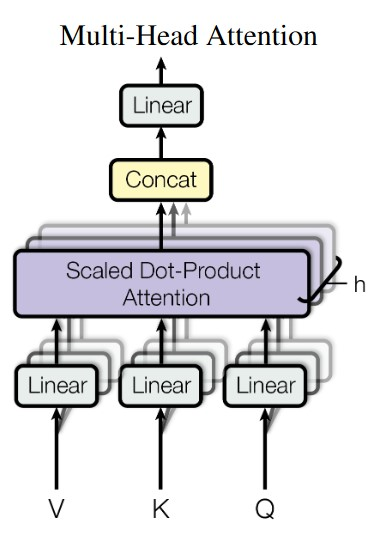

In [1]:
from IPython.display import Image
Image("multi-head-attention.jpg", width="200")

### Transformer Block

So far, we directly calculated the logits after the attention block, but this was way too fast - intuitively "the tokens looked at each other, but didn't really have time to think on what they found from the other tokens". Therefore, we add a feedforward single layer followed by a ReLU nonlinearity. Both layers together are called the **Transformer Block**, where we combine **communication** (self-attention) with **computation** (feedforward layer). This is on a per token level: Each token independently looks at the other tokens, and once it has gathered all the data, it thinks on that data individually. We implement this in the `Block` class below. The transformer block gets repeated over and over again.

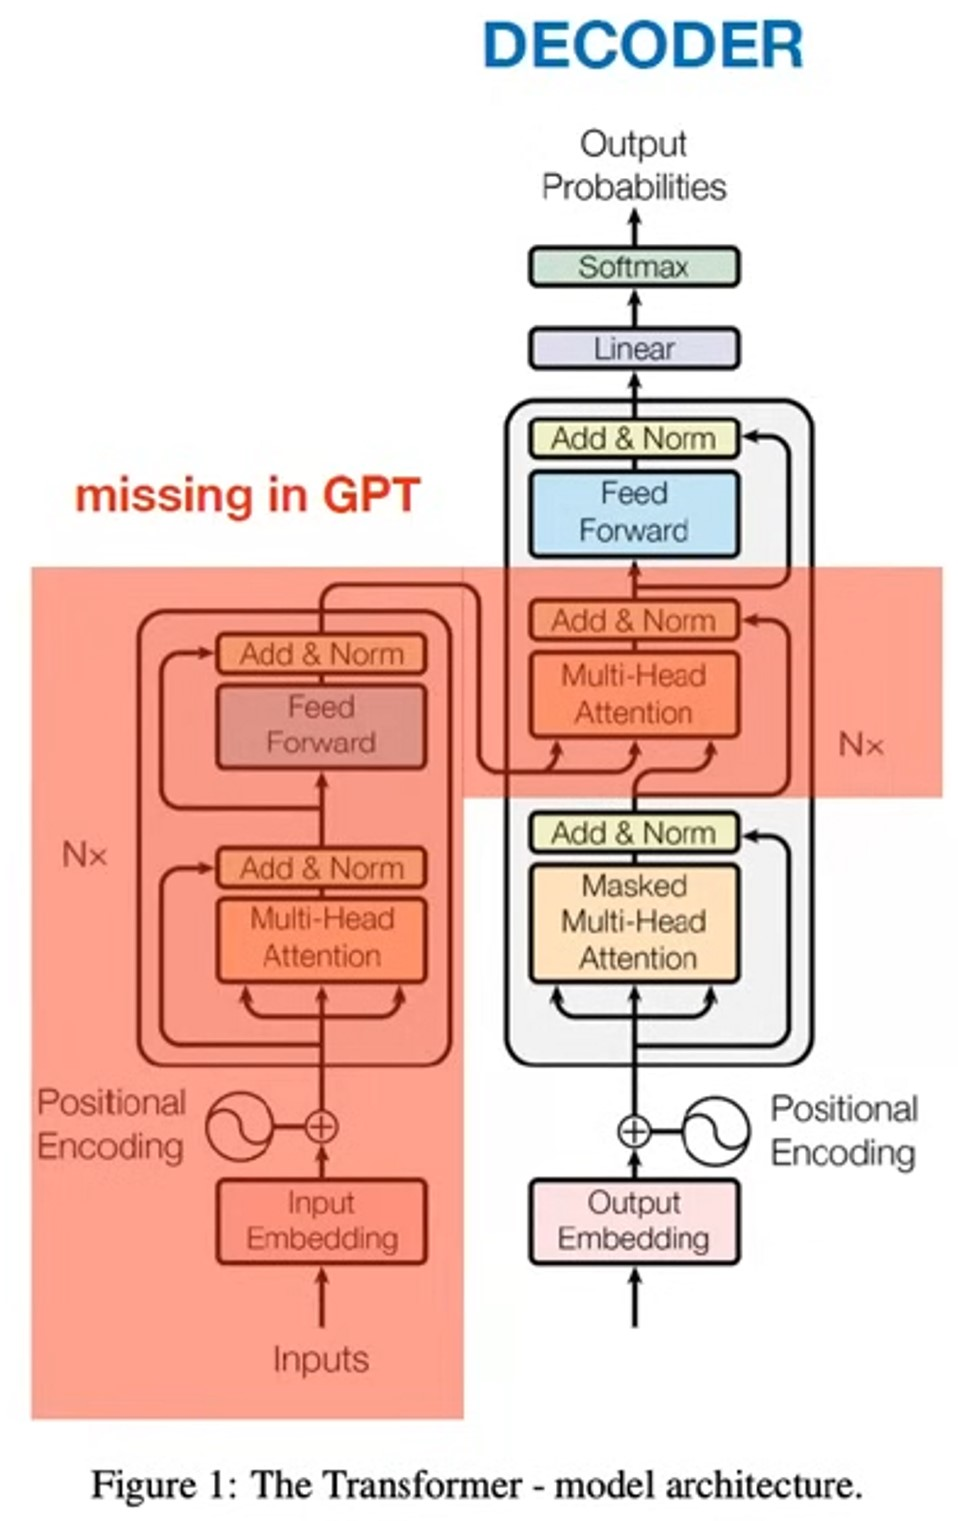

In [2]:
from IPython.display import Image
Image("transformer.jpg", width="300")

### Skip Connections

Also note that the transformer architecture above contains **skip connections (residual connections)**: The network contains parallel paths (one with some computations, one with the identity as "shortcut") that are combined via additions. Additions are great for backpropagation because they distribute gradients equally to both branches, so there is a "shortcut" for the gradients to directly propagate from the output to the input of the network. This avoids the vanishing gradient problem especially in the beginning - the transformer blocks only get more influence over time.

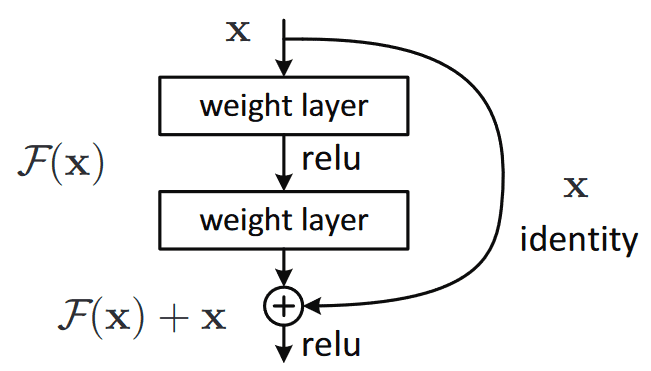

In [3]:
from IPython.display import Image
Image("skip-connection.png", width="300")

### Layer Norm

The transformer architecture uses **layer norm** (called "Norm" in the architecture image above), which is very similar to **batch norm**: Batch norm makes sure that across the batch dimension, any individual neuron has unit gaussian distribution (zero mean, unit standard deviation). In layer norm, we don't normalize the columns, but the rows, which normalizes over layers instead of over batches:

\begin{equation*}
y=\frac{x-E[x]}{\sqrt{Var[x]+\varepsilon}}\cdot \gamma + \beta,
\end{equation*}

where $\gamma$ and $\beta$ are learned.

In [41]:
class LayerNorm1d: # (copied from BatchNorm1d in makemore series)

  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)

  def __call__(self, x):
    # calculate the forward pass
    xmean = x.mean(1, keepdim=True) # previous batch mean -> index changed from 0 to 1
    xvar = x.var(1, keepdim=True) # previous batch variance -> index changed from 0 to 1
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # no running mean and variance buffers needed like in batch norm
    return self.out

  def parameters(self):
    return [self.gamma, self.beta]

torch.manual_seed(1337)
module = LayerNorm1d(100)
x = torch.randn(32, 100) # batch size 32 of 100-dimensional vectors
x = module(x)
x.shape

torch.Size([32, 100])

**TODO:** 8a) Check if mean and standard deviation of rows and/or columns are normalized now! Write the result in the answer cell. **(2 points)**

In [42]:
# YOUR CODE GOES HERE
# columns are not normalized anymore:
print(x[:,0].mean(), x[:,0].std()) # mean,std of one feature across all batch inputs

# rows are normalized instead:
x[0,:].mean(), x[0,:].std() # mean,std of a single input from the batch, of its features

tensor(0.1469) tensor(0.8803)


(tensor(-9.5367e-09), tensor(1.0000))

**ANSWER:** We can see that rows are normalized now instead of columns.

Note that layer norm is usually applied before the self-attention and linear layer nowadays (unlike the original paper) - one of the very few changes of the transformer architecture during the last years, otherwise mostly the architecture remained unchanged. This is called the **pre-norm formulation**. So here is a code snippet used below showing the two layer norms we will implement, one before the self-attention and one before the linear layer:

```
        x = x + self.sa(self.ln1(x)) # layer norm directly applied to x before self-attention
        x = x + self.ffwd(self.ln2(x)) # layer norm applied before linear layer
```

Finally, another layer norm is typically applied at the end of the Transformer and right before the final linear layer that decodes into vocabulary. 

The size of the layer norm is `n_embds=32` here, so this is a per token transformation, it just normalizes the features and makes them unit Gaussian at initialization. Because these layer norms contain gamma and beta as trainable parameters, the layer norm may eventually create outputs that are not unit Gaussian depending on the optimization.

### Scaling Up the Model

We now have all components together so that we can scale up the model and make it bigger. Therefore, we add a parameter `n_layer=4` to specify that we want 4 transformer blocks.

We also add **dropout** to prevent overfitting: with 4 transformer blocks, the network is getting quite large now. Therefore, we randomly deactivate some connections to prevent them from becoming too dominant. Because the mask of what's being dropped out has changed every single forward backward pass, effectively we end up training an ensemble of sub-networks. At test time, everything is fully enabled and all of those sub-networks are merged into a single ensemble, making it more robust.

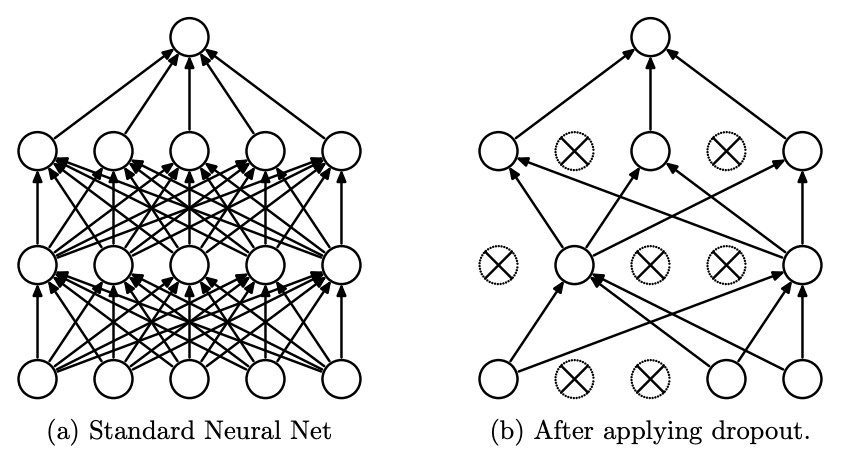

In [4]:
from IPython.display import Image
Image("dropout.png", width="300")

### Full GPT with Multi-Head Attention and Transformer Block

We finally get to the full GPT code, adding all the components explained above!

**TODO:** 8b) In the summarized code below, comment each line to make sure you have understood all GPT components! You may use support from ChatGPT or GitHub Copilot, but double-check the results and be able to explain it yourself. (Yes, this is tedious, but it will help you get an in-depth understanding of the full GPT architecture) **(10 points)**

In [43]:
# hyperparameters version 1 - start here
batch_size = 16 # how many independent sequences will we process in parallel?
block_size = 32 # what is the maximum context length for predictions?
max_iters = 5000 # how many training iterations?
eval_interval = 500 # how often to evaluate the loss on train and val sets
learning_rate = 1e-3 # learning rate
eval_iters = 200 # how many samples to evaluate the loss on (result = mean over eval_iters)
n_embd = 64 # embedding dimension
n_head = 4 # number of heads in multi-head attention
n_layer = 4 # number of transformer blocks
dropout = 0.2 # dropout rate 

# hyperparameters version 2 - only uncomment when training on GPU
#"""
batch_size = 64 # how many independent sequences will we process in parallel?
block_size = 256 # what is the maximum context length for predictions?
max_iters = 5000 # how many training iterations?
eval_interval = 500 # how often to evaluate the loss on train and val sets
learning_rate = 3e-4 # learning rate
eval_iters = 200 # how many samples to evaluate the loss on (result = mean over eval_iters)
n_embd = 384 # embedding dimension
n_head = 6 # number of heads in multi-head attention
n_layer = 6 # number of transformer blocks
dropout = 0.2 # dropout rate 
#"""

# ------------

device = 'cuda' if torch.cuda.is_available() else 'cpu' # check if GPU is available
print('Running on device:',device) # print the device

# data loading
def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data # use the correct data
    ix = torch.randint(len(data) - block_size, (batch_size,)) # sample random starting indices
    x = torch.stack([data[i:i+block_size] for i in ix]) # stack them together
    y = torch.stack([data[i+1:i+block_size+1] for i in ix]) # the targets are one token ahead
    x, y = x.to(device), y.to(device) # move to GPU if available
    return x, y # return the batch

@torch.no_grad() # we don't need gradients for this function (more efficient)
def estimate_loss(): # average loss over eval_iters iterations
    out = {} # store the results in this dictionary
    model.eval() # switch to eval mode (not relevant here because no dropout etc., but good practice)
    for split in ['train', 'val']: # evaluate both on train and val
        losses = torch.zeros(eval_iters) # store the loss values
        for k in range(eval_iters): # iterate over eval_iters
            X, Y = get_batch(split) # get a batch
            logits, loss = model(X, Y) # compute the loss 
            losses[k] = loss.item() # store the losses
        out[split] = losses.mean() # store the mean loss in the dictionary
    model.train() # switch back to train mode
    return out # return the dictionary

class Head(nn.Module): 
    """ one head of self-attention """

    def __init__(self, head_size): # head_size = n_embd // n_head
        super().__init__() # initialize the module
        self.key = nn.Linear(n_embd, head_size, bias=False) # define the linear layer for key. Typically no bias is used in self-attention
        self.query = nn.Linear(n_embd, head_size, bias=False) # define the linear layer for query
        self.value = nn.Linear(n_embd, head_size, bias=False) # define the linear layer for value
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size))) # buffer = not a parameter; masking with lower triangular matrix

        self.dropout = nn.Dropout(dropout) # dropout layer for regularization

    def forward(self, x): # forward pass of the input x through the module
        B,T,C = x.shape # batch, time, channels
        k = self.key(x)   # (B,T,C) - apply the key linear layer
        q = self.query(x) # (B,T,C) - apply the query linear layer

        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * k.shape[-1]**-0.5 # (B, T, hs) @ (B, hs, T) -> (B, T, T) - scale by head_size**-0.5 (normalization from original paper, see above)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T) - mask out the future
        wei = F.softmax(wei, dim=-1) # (B, T, T) - apply softmax to get the weights
        wei = self.dropout(wei) # apply dropout for regularization

        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,C) - apply the value linear layer
        out = wei @ v # (B, T, T) @ (B, T, C) -> (B, T, C) - weighted aggregation = self-attention
        return out # return the result

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size): 
        super().__init__() # initialize the module
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)]) # create num_heads heads
        self.proj = nn.Linear(n_embd, n_embd) # project back to the original pathway
        # Note: "projection" in the context of Transformer models refers to a linear transformation
        # that can either maintain, reduce, or even increase the dimensionality of the data.
        # The projection layer combines the concatenated outputs from all heads into a single unified representation.
        self.dropout = nn.Dropout(dropout) # dropout layer for regularization

    def forward(self, x): # forward pass of the input x through the module
        out = torch.cat([h(x) for h in self.heads], dim=-1) # concatenate output of each head
        out = self.dropout(self.proj(out)) # project back to the original pathway and apply dropout
        return out # return the result

class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd): # n_embd: embedding dimension (e.g., 64 or 384)
        super().__init__() # initialize the module
        self.net = nn.Sequential( # simple feed forward network
            nn.Linear(n_embd, 4 * n_embd), # grow the hidden layer by a factor of 4 (see original paper)
            nn.ReLU(), # ReLU activation function
            nn.Linear(4 * n_embd, n_embd), # project back to the original pathway
            nn.Dropout(dropout), # dropout layer for regularization
        )

    def forward(self, x): # forward pass of the input x through the module
        return self.net(x) # return the result

class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head): # n_embd: embedding dimension, n_head: the number of heads we'd like 
        super().__init__() # initialize the module
        head_size = n_embd // n_head # each head will have this size because we split the embedding into n_head parts
        # (typical transformer structure: n_embd is divisible by n_head)
        self.sa = MultiHeadAttention(n_head, head_size) # self-attention layer
        self.ffwd = FeedFoward(n_embd) # feed forward layer
        self.ln1 = nn.LayerNorm(n_embd) # layer norm for the self-attention
        self.ln2 = nn.LayerNorm(n_embd) # layer norm for the feed forward

    def forward(self, x):
        # typical transformer block: multi-head attention followed by feed forward including skip connections
        # note that layer norm is applied before the self-attention nowadays (unlike the original paper)
        x = x + self.sa(self.ln1(x)) # residual connection + layer norm + self-attention
        x = x + self.ffwd(self.ln2(x)) # residual connection + layer norm + feed forward
        return x

# language model now using attention 
class GPTLanguageModel(nn.Module):
    """ GPT language model with self-attention """

    def __init__(self):
        super().__init__() # initialize the module
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd) # token embedding according to identity (e.g., first character in vocabulary)
        self.position_embedding_table = nn.Embedding(block_size, n_embd) # positional encoding according to position in text (e.g., first character in text)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)]) # stack of transformer blocks
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm (typically added after the transformer stack, right before the final linear layer that decodes into the vocabulary)
        self.lm_head = nn.Linear(n_embd, vocab_size) # linear layer to decode into the vocabulary

    def forward(self, idx, targets=None): # targets are optional during inference
        B, T = idx.shape # batch size and time

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C) - get token embeddings
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C) - integers from 0 to T-1 for position embeddings
        x = tok_emb + pos_emb # (B,T,C) via broadcasting (pos_emb gets right-aligned, new dimension of 1 gets added, broadcasted across batch)
        x = self.blocks(x) # (B,T,C) - transformer block
        x = self.ln_f(x) # (B,T,C) - final layer norm
        logits = self.lm_head(x) # (B,T,vocab_size) - predict the logits

        if targets is None: # during inference we only need the logits
            loss = None # loss is therefore None
        else:
            B, T, C = logits.shape # store the shape of the logits
            logits = logits.view(B*T, C) # reshape (B,T,C) -> (B*T,C) for cross entropy to work (see https://pytorch.org/docs/stable/nn.html#torch.nn.CrossEntropyLoss)
            targets = targets.view(B*T) # reshape targets similarly
            loss = F.cross_entropy(logits, targets) # cross entropy loss

        return logits, loss # return the logits and loss

    def generate(self, idx, max_new_tokens): # generate from the model
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens): # generate max_new_tokens
            idx_cond = idx[:, -block_size:] # crop idx to the last block_size tokens (will run out of memory if bigger than block_size)
            logits, loss = self(idx_cond)  # get the predictions
            logits = logits[:, -1, :] # (B, C) - focus only on the last time step
            probs = F.softmax(logits, dim=-1) # (B, C) - apply softmax to get probabilities
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1) - sample from the distribution
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1) - append sampled index to the running sequence
        return idx


model = GPTLanguageModel() # create the model
model = model.to(device) # move the model to the GPU if available

print(sum(p.numel() for p in model.parameters())/1e6, 'M parameters') # print the number of parameters in the model

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate) # create a PyTorch optimizer

for iter in range(max_iters): # iterate over the dataset

    if iter % eval_interval == 0 or iter == max_iters - 1: #every once in a while evaluate the loss on train and val sets
        losses = estimate_loss() # estimate the loss
        print("\n==============")
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}") # print the results
        print("==============")
        
        # generate from the model
        print("\nSample:")
        context = torch.zeros((1, 1), dtype=torch.long, device=device) # create context on the GPU if available (start with a single token = 0)
        print(decode(model.generate(context, max_new_tokens=200)[0].tolist())) # generate a sample wit 200 tokens and decode it

    # sample a batch of data
    xb, yb = get_batch('train') 

    # evaluate the loss
    logits, loss = model(xb, yb) # forward pass of the input through the model
    optimizer.zero_grad(set_to_none=True) # set the gradients to zero
    loss.backward() # backward pass to compute the gradients
    optimizer.step() # update the weights

# generate from the model
print("\nFinal sample:") # generate a sample with 2000 tokens
context = torch.zeros((1, 1), dtype=torch.long, device=device) # create context on the GPU if available (start with a single token = 0)
print(decode(model.generate(context, max_new_tokens=2000)[0].tolist())) # generate a sample with 2000 tokens and decode it


Running on device: cuda
10.788929 M parameters

step 0: train loss 4.3684, val loss 4.3590

Sample:

SaVqulef&&;giKUCZo

D?QZFFmlHHkPkBj!'VTSbmRDynJeCHXEU.n;O,h&MHKRP

qkjne AURe!PV$!EAyC Dbu$IbDKIGEff.Ca-F$SrYHIarCbcV
xwkOu'Ww.WvxFxwFfRdI.LIzfmSBaw?ia
Ib,3O3lE;maEwTcGGqmFlxHmshIqmUrObTsrcXwFz?agwGpP

step 500: train loss 1.9148, val loss 2.0104

Sample:

Sisnding surncr: amest to him the and somen
The will leve of of tousark, and cable.
KIF dewastays le is biose tat will nith fortughtit'd ans?
Le:
Fom my le, I shyince dor may magend
Fromefike of therd

step 1000: train loss 1.5542, val loss 1.7388

Sample:

And VIVALINA:
How now not bawight o'er wich make, away yetter,
be deothernabe word make, our such rember.

ServENERYn:
I woman in the ind.
Give me.
No his, when dive or bat the baste? O muchus hart,
A

step 1500: train loss 1.4067, val loss 1.6229

Sample:

Maboure:
Braces meet! childrew, as out me in he bad; I
must not shall-mother; cride than or a diance, poil two heart
Hither th

That's it! We have trained a more powerful GPT model using self-attention. Let's generate a longer text and see how the results look like:

In [44]:
# generate a longer sample
context = torch.zeros((1, 1), dtype=torch.long, device=device)
new_text = decode(model.generate(context, max_new_tokens=10000)[0].tolist())
print(new_text)


Lady:
Who says are makes amen.

GLOUCESTER:
So brother's good wife?  not so far, now.

PRINCE EDWARD:
No, neithers, lords.

KING RICHARD III:
Art tire; for there the devil at the city.

GLOUCESTER:
To patient fears them that thiness old of quine,
And tell is it to be yield.

KING EDWARD IV:
Not good coming my way.

KING EDWARD IV:
Did up, trumpet! it shall be us too star'd.

YORK:
Then besides all waiting by the Tower,
Or what will I show, ere device
Still by darments, the most toill to your evil use
He thither I did not weigh in sin:--
I through it should leave,--my follow's in our neck,
And my sons weddest in iman-gain,
I shall excrow your queen on.

LUCIO:
O your vicely, if you have wear eye of little more
Is hugging.

LUCIO:
Such hasopiniorer, talks smoke the pricks.
I should besief sool, a next, you do enter form!

BRUTUS:
That  Cholers so here, with noble course.

CORIOLANUS:
Answear me, rail, I'll cannot low.
I have, I saw the cound of my backness,
And might for my gazes death:

In [45]:
# save result to a text file
f =  open("text_output/GPT_generated_text.txt","w")
f.write(new_text)
f.close()

**TODO (optional):** Apply the code to a different text of your choice! What loss do you achieve? What parameters did you change and why? How do you interpret the output compared to the Shakespeare output?

## 9. Outlook and Next Steps
### Andrej's Suggested Further Experiments

- EX1: The n-dimensional tensor mastery challenge: Combine the `Head` and `MultiHeadAttention` into one class that processes all the heads in parallel, treating the heads as another batch dimension (answer is in nanoGPT).
- EX2: Train the GPT on your own dataset of choice! What other data could be fun to blabber on about? (A fun advanced suggestion if you like: train a GPT to do addition of two numbers, i.e. a+b=c. You may find it helpful to predict the digits of c in reverse order, as the typical addition algorithm (that you're hoping it learns) would proceed right to left too. You may want to modify the data loader to simply serve random problems and skip the generation of train.bin, val.bin. You may want to mask out the loss at the input positions of a+b that just specify the problem using y=-1 in the targets (see CrossEntropyLoss ignore_index). Does your Transformer learn to add? Once you have this, swole doge project: build a calculator clone in GPT, for all of +-*/. Not an easy problem. You may need Chain of Thought traces.)
- EX3: Find a dataset that is very large, so large that you can't see a gap between train and val loss. Pretrain the transformer on this data, then initialize with that model and finetune it on tiny shakespeare with a smaller number of steps and lower learning rate. Can you obtain a lower validation loss by the use of pretraining?
- EX4: Read some transformer papers and implement one additional feature or change that people seem to use. Does it improve the performance of your GPT?

### Decoder and Encoder

Text generation as above only uses the **decoder** part of the transformer architecture. The **decoder attention block** implemented above has **triangular masking**, and is usually used in autoregressive settings, like language modeling. 

In other settings, we do want "future" tokens to influence the prediction, so we do not use triangular masking. For example, in sentiment analysis, we look at a whole sentence at once, then predict the sentiment "happy" or "sad" of the speaker. This can be realized using an **encoder** attention block. To implement an encoder attention block, we can simply delete the single line that does masking with `tril`, allowing all tokens to communicate. Attention does not care whether tokens from the future contribute or not, it supports arbitrary connectivity between nodes.

### From Self-Attention to Cross-Attention

**Self-attention** means that the keys and values are produced from the same source as queries. In **cross-attention**, the queries still get produced from `x`, but the keys and values come from some other, external source (e.g. an encoder module). For example, when translating from French to English, we condition the decoding on the past decoding *and* the fully encoded french prompt. 

In [46]:
# French to English translation example:

# <--------- ENCODE ------------------><--------------- DECODE ----------------->
# les réseaux de neurones sont géniaux! <START> neural networks are awesome!<END>



### From GPT to ChatGPT



There is still a long way to go from our toy GPT example to ChatGPT. 
First of all, ChatGPT's **pre-training** was done on a large chunk of internet, resulting in a decoder-only transformer for text generation. 
So the pretraining is quite similar to our toy example training, except that we used roughly 10 million parameters and the largest transformer for ChatGPT uses 175 billion (!) parameters. Also it was trained on 300 billion tokens (our training set would be 300.000 tokens roughly when not using character-level tokens, but sub-word chunks). This is about a million fold increase in number of tokens - and today, even bigger datasets are used with trillions of tokens for training on thousands of GPUs!

See the following table for the number of parameters, number of layers, n_embd, number of heads, head size, batch size and learning rate in **GPT-3**:

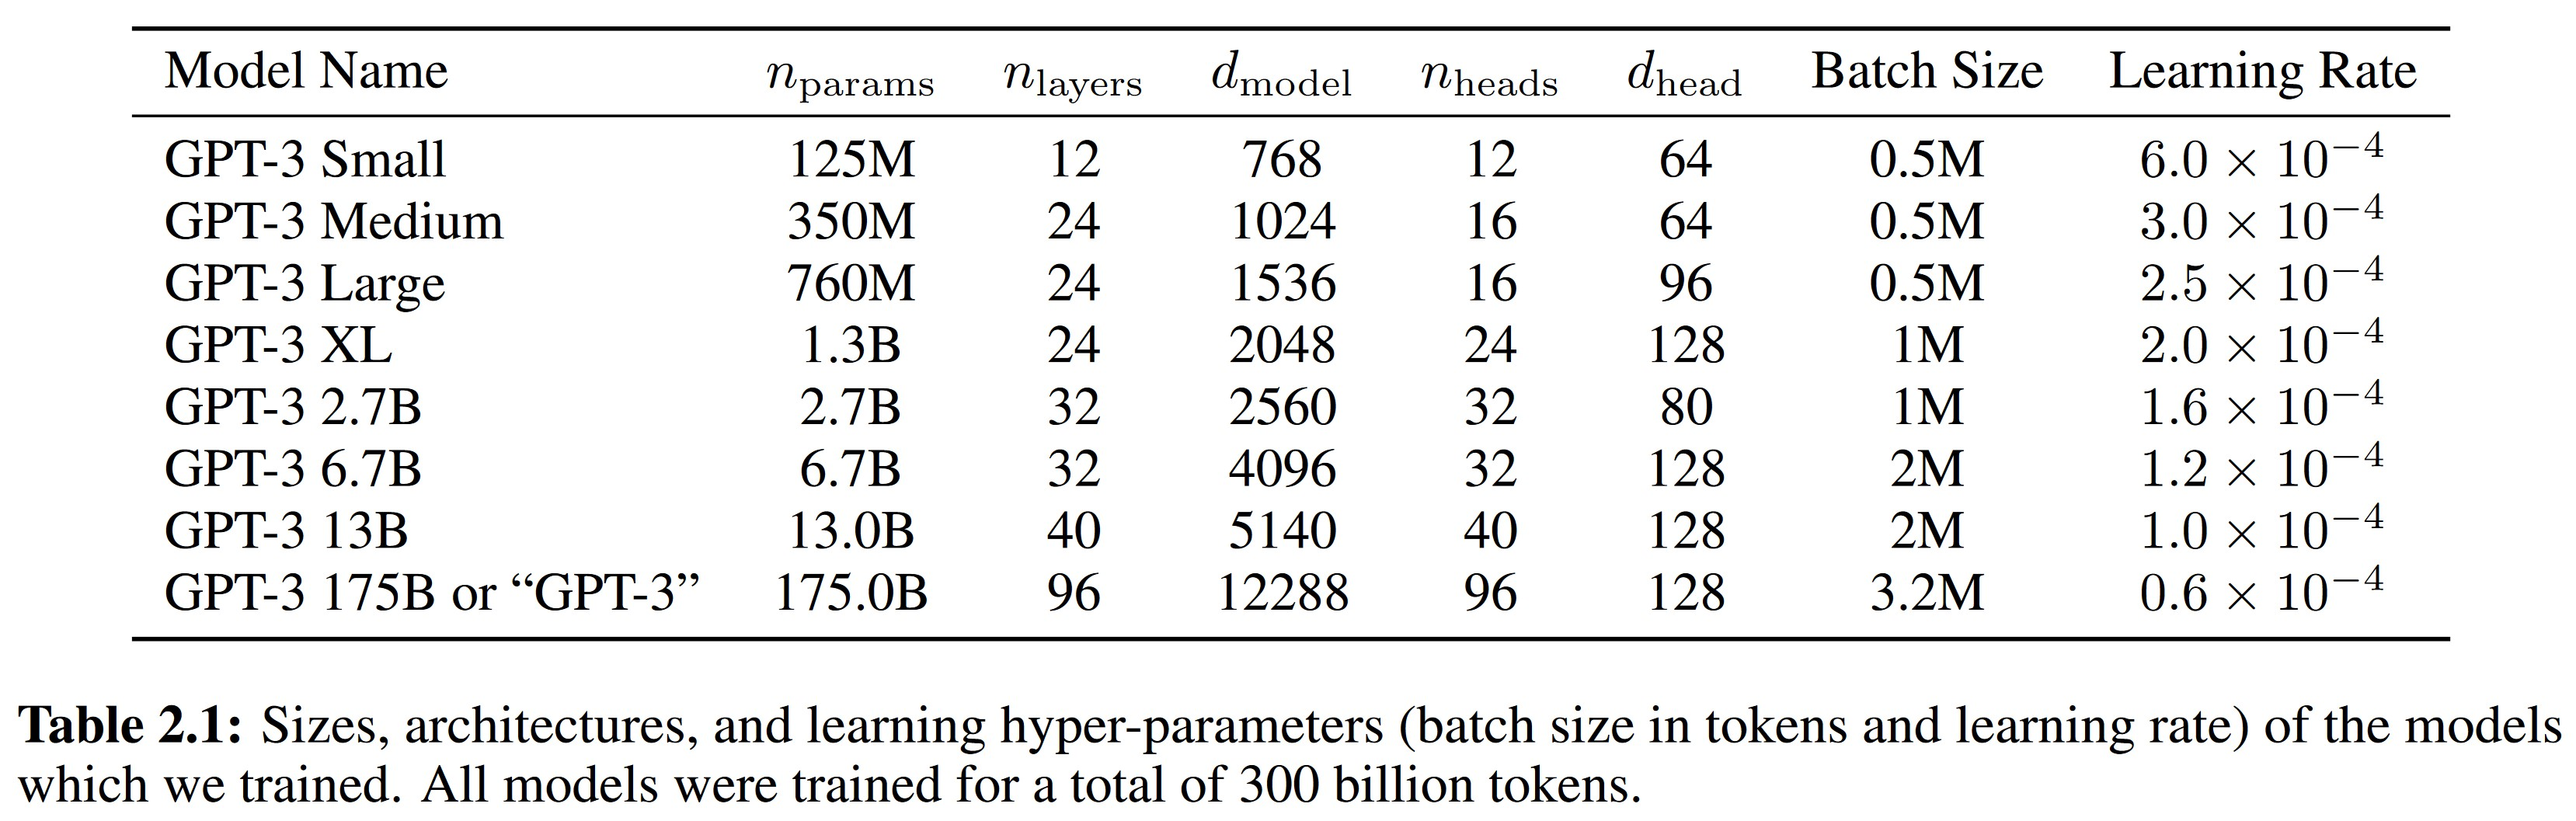

In [5]:
from IPython.display import Image
Image("GPT3_params_table.jpg", width="800")

After the pre-training, the model will be a document completer, it will not give answers but produce more questions or result in some undefined behavior. For becoming an assistant, further **fine-tuning** is needed using **Reinforcement Learning from Human Feedback (RLHF)**. Here is an overview of manual fine-tuning with human AI trainers (see the OpenAI ChatGPT blog for details, link below):

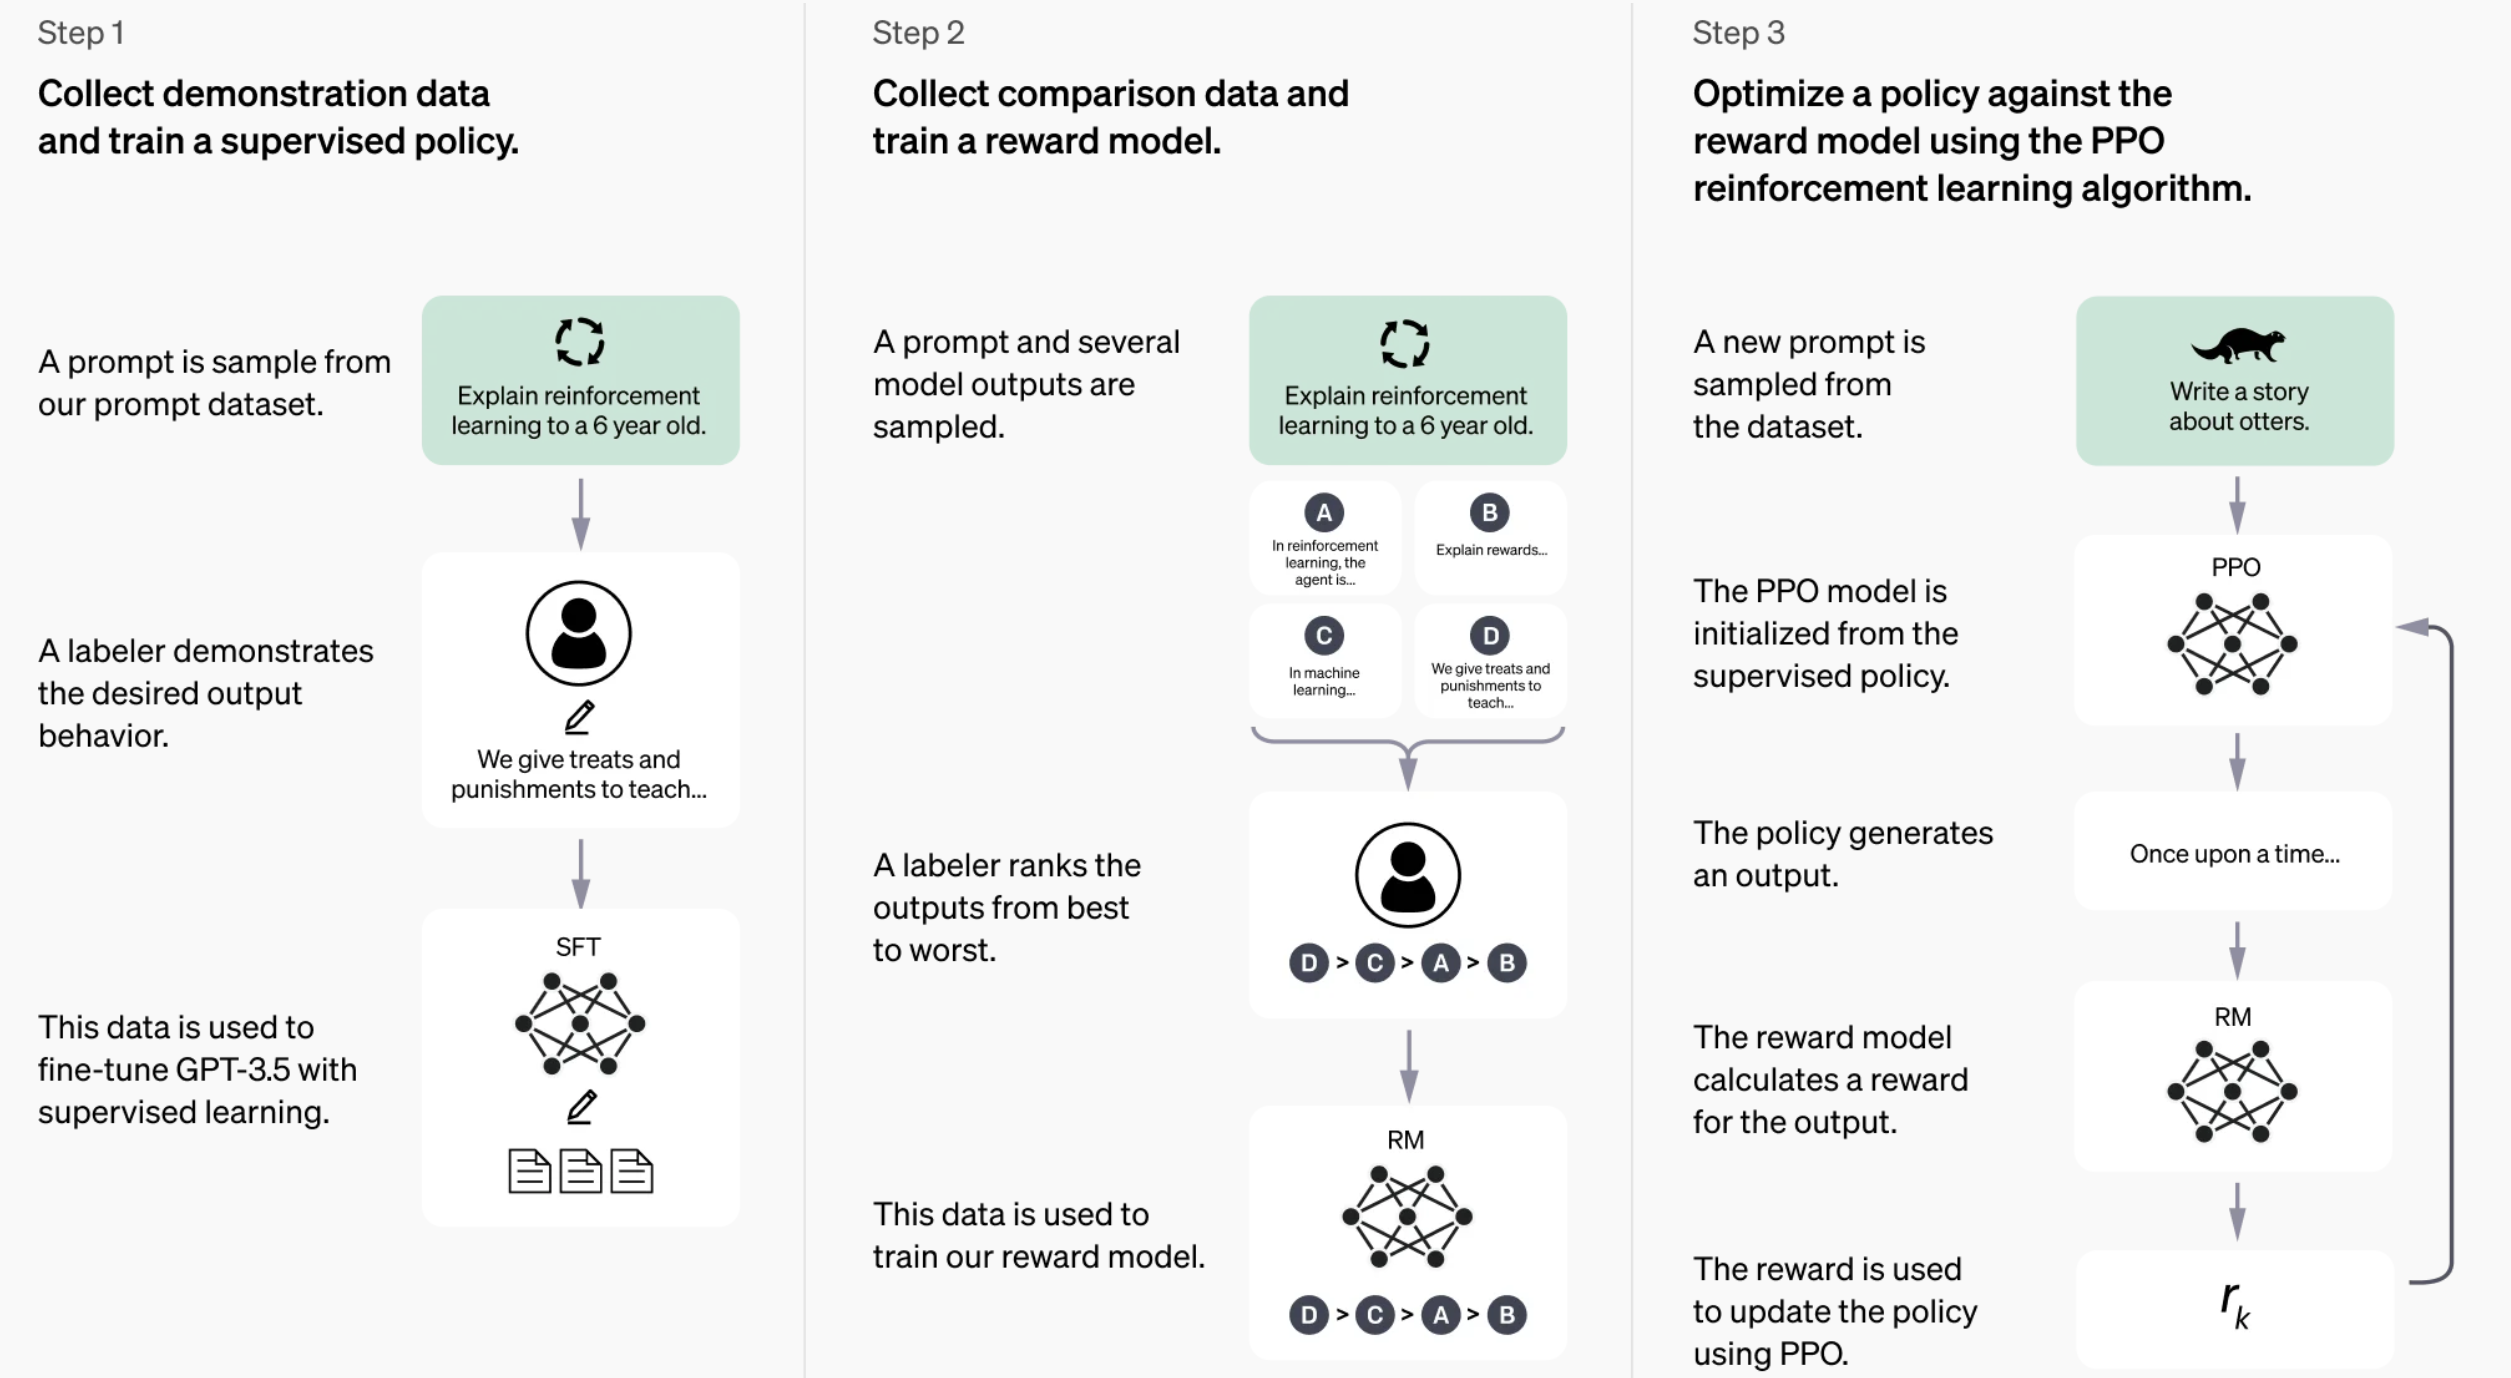

In [10]:
from IPython.display import Image
Image("chatgpt_diagram_light.png", width="800")

### Summary

To sum it up, we trained a decoder only Transformer following the famous paper 'Attention is All You Need' from 2017, which is basically a GPT. We saw how using self-attention, we can calculate a weighted average of past tokens to predict the next token. We trained it on different texts (Shakespeare, Faust, Jane Austen etc.) and produced new texts in the same writing style. 

### Further Reading

- Attention is All You Need paper: https://arxiv.org/abs/1706.03762
- OpenAI GPT-3 paper: https://arxiv.org/abs/2005.14165 
- OpenAI ChatGPT blog post: https://openai.com/blog/chatgpt/

In [11]:
# Uncomment to convert the notebook to pdf for submission 
# NOTE: You may have to adapt the path or filename to match your local setup
!jupyter nbconvert --to webpdf --allow-chromium-download 3_Character_Level_GPT__solution.ipynb

[NbConvertApp] Converting notebook 3_Character_Level_GPT__solution.ipynb to webpdf
[NbConvertApp] WARNING | Alternative text is missing on 6 image(s).
[NbConvertApp] Building PDF
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 1831239 bytes to 3_Character_Level_GPT__solution.pdf
